This is a Demo for using the SlidingWindow Symmetry Analysis provided in ctntools git repository 'https://github.com/ctnelson/ctntools.git'

Created 2024 by Dr. Christopher Nelson
Oak Ridge National Laboratory

# Imports

Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
try:
  from git import Repo,  InvalidGitRepositoryError
except:
  !pip install GitPython
  from git import Repo,  InvalidGitRepositoryError

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


Custom GIT Imports

In [2]:
gitlocal = ''
for i in sys.path:
    temp=i.split('\\')
    if temp[-1]=='site-packages':
        gitlocal=i

In [3]:
#Set local git repository location
gitremote = 'https://github.com/ctnelson/ctntools.git'
gitl = os.path.join(gitlocal,'ctntools')
print(gitl)

ctntools


In [4]:
#check for local repo, pull if found
#clone git repo if not found locally
if os.path.exists(gitl):
    try:
        my_repo = Repo(gitl)
        o = my_repo.remotes.origin
        o.pull()
    except InvalidGitRepositoryError:
        Repo.clone_from(gitremote, gitl)
        my_repo = Repo(gitl)
else:
    Repo.clone_from(gitremote, gitl)
    my_repo = Repo(gitl)
print(my_repo)

<git.repo.base.Repo '/content/ctntools/.git'>


In [7]:
#Import custom functions from git repo
from ctntools.BaseSupportFunctions.createDataset import createDataset               #create artificial datasets
from ctntools.StructureAnalysis.imSymmMap import imSymmMap                          #symmetry mapping function
from ctntools.SlidingWindow.swMtransf_radial_CC import swMtransf_IJradial_CC        #this is the lower-level mapping function, use this if you have a custom transform matrix

# Create a Dataset

In [23]:
#2 atom hex
bounds = [0,128,0,64]                                                        #window
samplestep = .25                                                              #meshgrid sampling step
sampMesh = [bounds[0],bounds[1],samplestep,bounds[2],bounds[3],samplestep]  #meshgrid parameters for sampling
#basis & primitive
mag=10                                                      #basis vector magnitude
alpha = np.deg2rad(60)                                      #internal angle
atheta = np.deg2rad(10)                                     #a vector orientation
a=[np.cos(atheta)*mag, np.sin(atheta)*mag]                  #a basis vector
b=[np.cos(alpha+atheta)*mag, np.sin(alpha+atheta)*mag]      #b basis vector
primitive = [[1/3,1/3,1,1,1,0],[2/3,2/3,2,1,1,0]]           #[a, b, A, s1, s2, theta]
#Noise
countsPerPrimitive = 1000                                   #shot noise
baseNoiseRng = .5                                           #additive gaussian noise

#create dataset
Dataset, _, _, atoms,_,_, mgparams,_ = createDataset(bounds=bounds, method='Grid',sampMesh=sampMesh, primitive=primitive ,a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'Dataset')

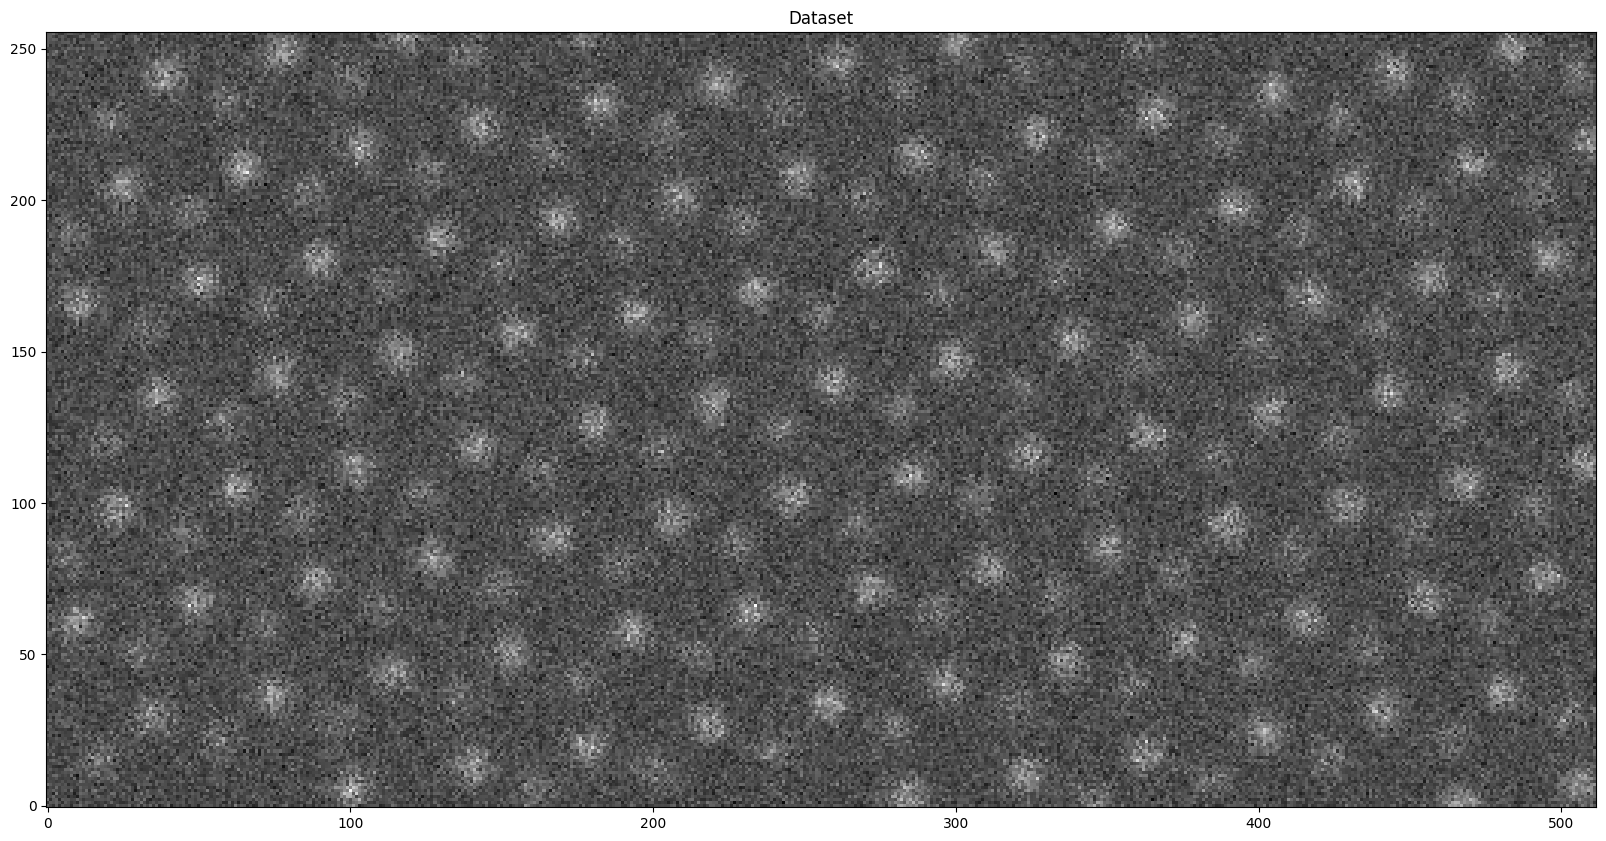

In [25]:
#display
fig, ax = plt.subplots(1, 1, figsize=(20,20), dpi = 100)
ax.imshow(Dataset,cmap='gray',origin='lower')
ax.set_title('Dataset')

# Example Transforms

Inversion (using shorthand dictionary input)

In [26]:
#Inversion
M = {'i':[]}                        #Basic symmetries can be checked by sending a Dictionary with {'i':} for inversion, {'r':[angle1,angle2...]} for rotation, {'m':[angle1,angle2,..]} for mirror.
r = 1.2*mag/mgparams[2]             #this is the radius the symmetry will be analyzed at each point
calc = 'ZeroNormCrossCorr'

In [27]:
swCC, swCounts, Mlbls = imSymmMap(Dataset, M, r, symmCalc=calc)

Text(0.5, 1.0, 'Inversion')

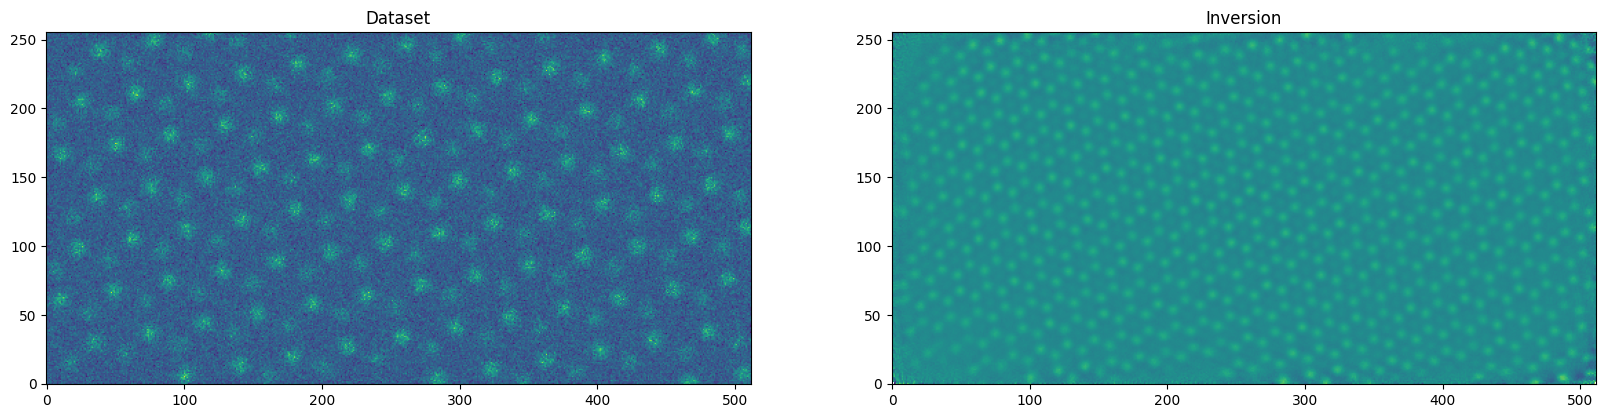

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(swCC,origin='lower')
ax[1].set_title('Inversion')

or explicitly define a transform matrix

Text(0.5, 1.0, 'Inversion')

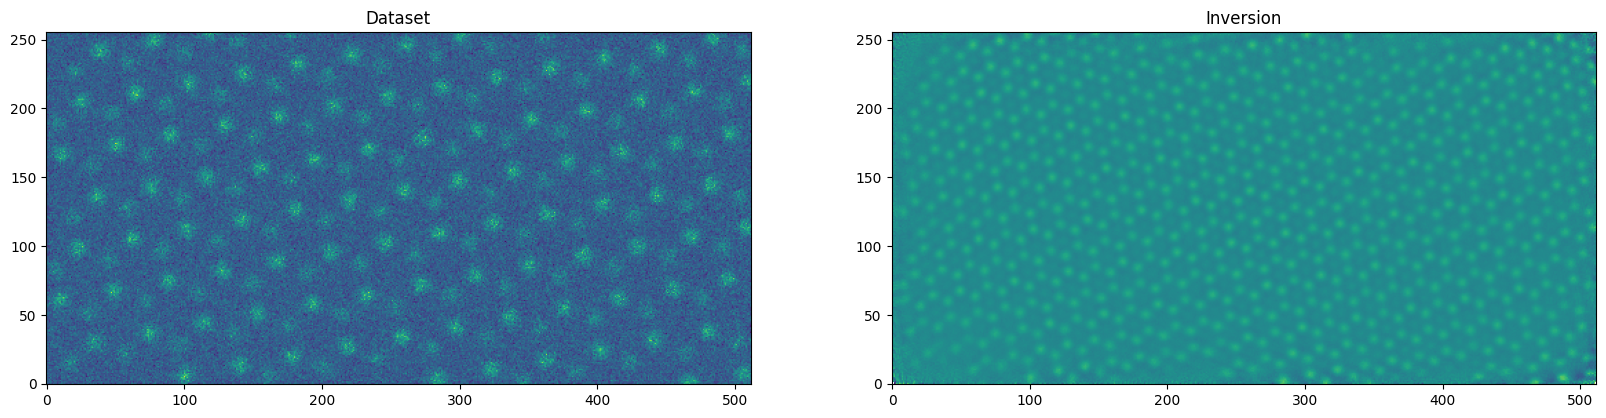

In [29]:
M = np.array([[-1,0],[0,-1]]) #inversion
swCC, swVar, swMean, swCounts = swMtransf_IJradial_CC(Dataset, M, r, calc=calc)

fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(swCC,origin='lower')
ax[1].set_title('Inversion')

Rotation

In [30]:
#rot=np.deg2rad(-60)
#M = np.array([[np.cos(rot),-np.sin(rot)],[np.sin(rot),np.cos(rot)]])
M = {'r':[-60]}

In [31]:
#swCC, swVar, swMean, swCounts = swMtransf_IJradial_CC(Dataset, M, r, calc=calc)
swCC, swCounts, Mlbls = imSymmMap(Dataset, M, r, symmCalc=calc)

Text(0.5, 1.0, 'Rotation (60deg)')

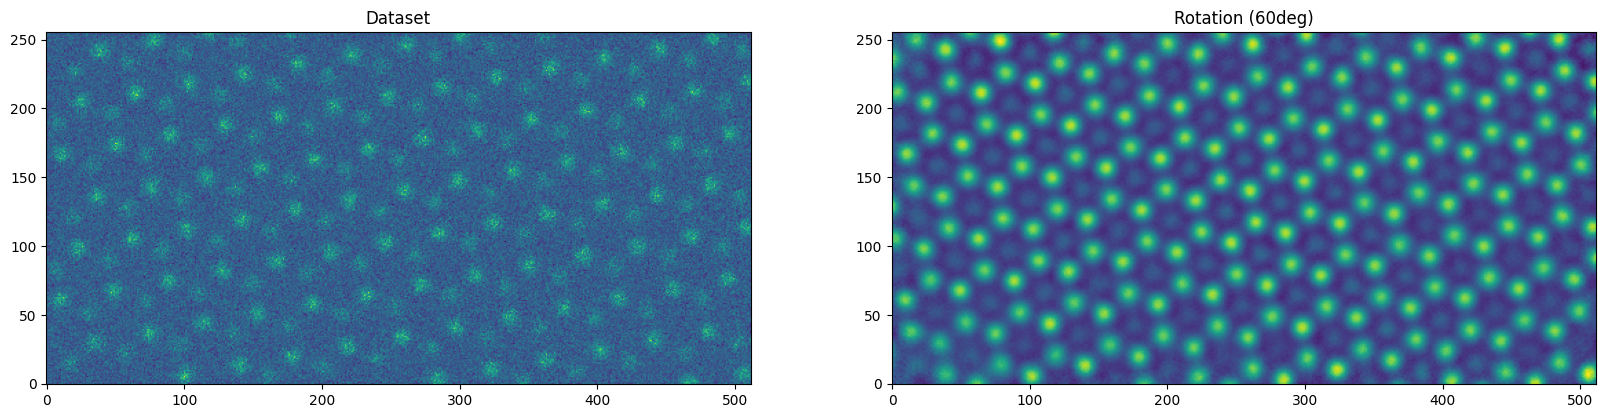

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(swCC,origin='lower')
ax[1].set_title('Rotation (60deg)')

Y plane mirror

In [33]:
#M = np.array([[1,0],[0,-1]])
#swCC, swVar, swMean, swCounts = swMtransf_IJradial_CC(Dataset, M, r, calc=calc)
M = {'m':[0]}
swCC, swCounts, Mlbls = imSymmMap(Dataset, M, r, symmCalc=calc)

Text(0.5, 1.0, 'Y-plane mirror')

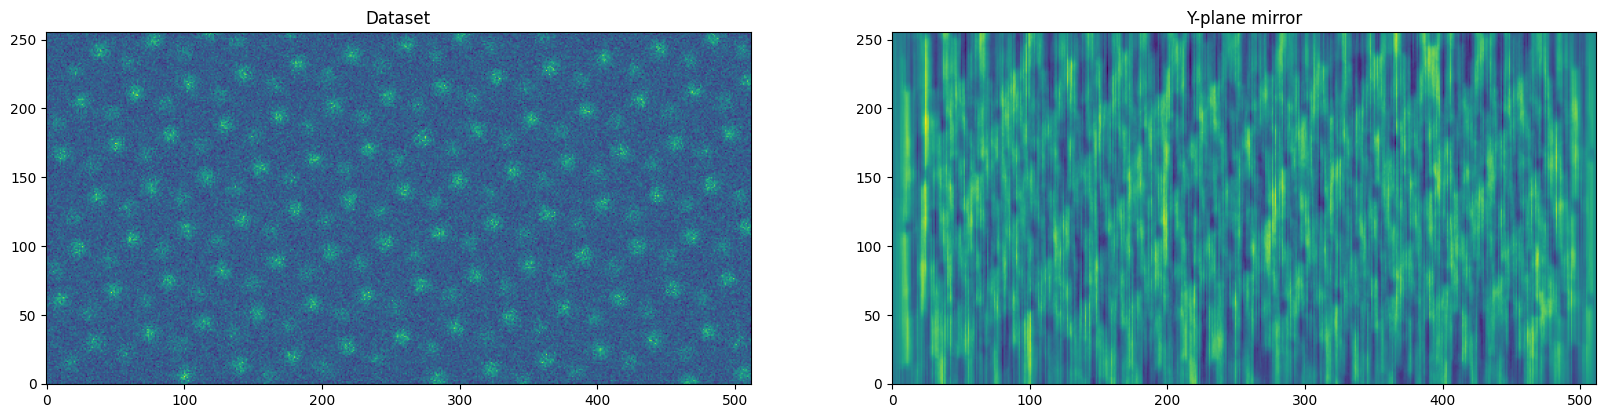

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(swCC*swCounts,origin='lower')
ax[1].set_title('Y-plane mirror')

X plane mirror

In [35]:
#M = np.array([[-1,0],[0,1]])
#swCC, swVar, swMean, swCounts = swMtransf_IJradial_CC(Dataset, M, r, calc=calc)
M = {'m':[90]}
swCC, swCounts, Mlbls = imSymmMap(Dataset, M, r, symmCalc=calc)

Text(0.5, 1.0, 'X-plane mirror')

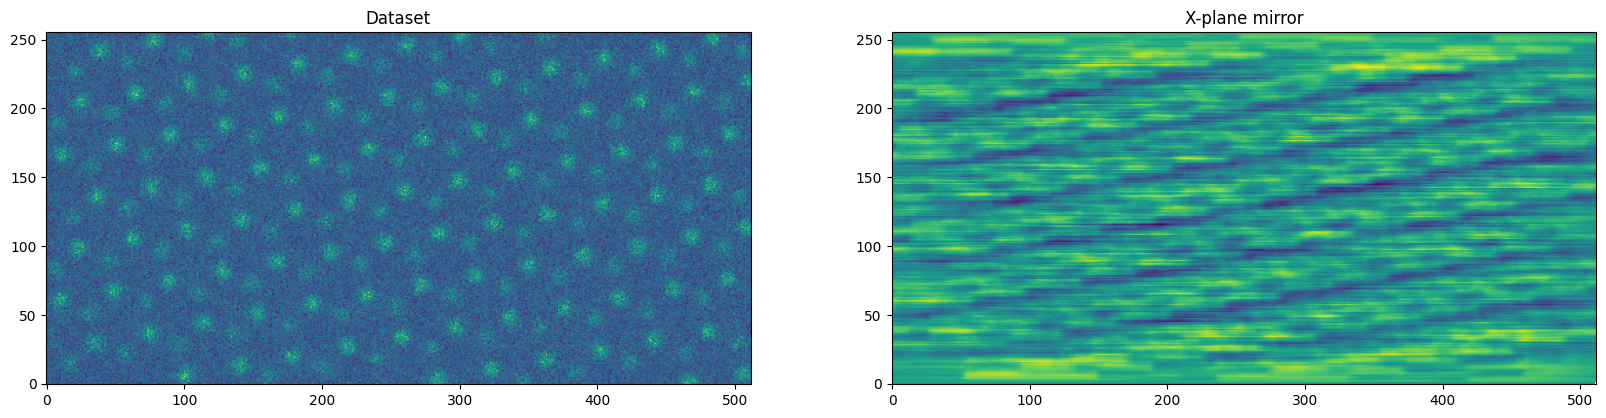

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(swCC*swCounts,origin='lower')
ax[1].set_title('X-plane mirror')

Multiangle Mirror

In [37]:
M = {'m':np.arange(-90,91,5)}
swCC, swCounts, Mlbls = imSymmMap(Dataset, M, r, symmCalc=calc, verbose=1)

0 Adding Mirror Symmetry -90.00 degrees
1 Adding Mirror Symmetry -85.00 degrees
2 Adding Mirror Symmetry -80.00 degrees
3 Adding Mirror Symmetry -75.00 degrees
4 Adding Mirror Symmetry -70.00 degrees
5 Adding Mirror Symmetry -65.00 degrees
6 Adding Mirror Symmetry -60.00 degrees
7 Adding Mirror Symmetry -55.00 degrees
8 Adding Mirror Symmetry -50.00 degrees
9 Adding Mirror Symmetry -45.00 degrees
10 Adding Mirror Symmetry -40.00 degrees
11 Adding Mirror Symmetry -35.00 degrees
12 Adding Mirror Symmetry -30.00 degrees
13 Adding Mirror Symmetry -25.00 degrees
14 Adding Mirror Symmetry -20.00 degrees
15 Adding Mirror Symmetry -15.00 degrees
16 Adding Mirror Symmetry -10.00 degrees
17 Adding Mirror Symmetry -5.00 degrees
18 Adding Mirror Symmetry 0.00 degrees
19 Adding Mirror Symmetry 5.00 degrees
20 Adding Mirror Symmetry 10.00 degrees
21 Adding Mirror Symmetry 15.00 degrees
22 Adding Mirror Symmetry 20.00 degrees
23 Adding Mirror Symmetry 25.00 degrees
24 Adding Mirror Symmetry 30.00 deg

Text(0.5, 1.0, 'mirror')

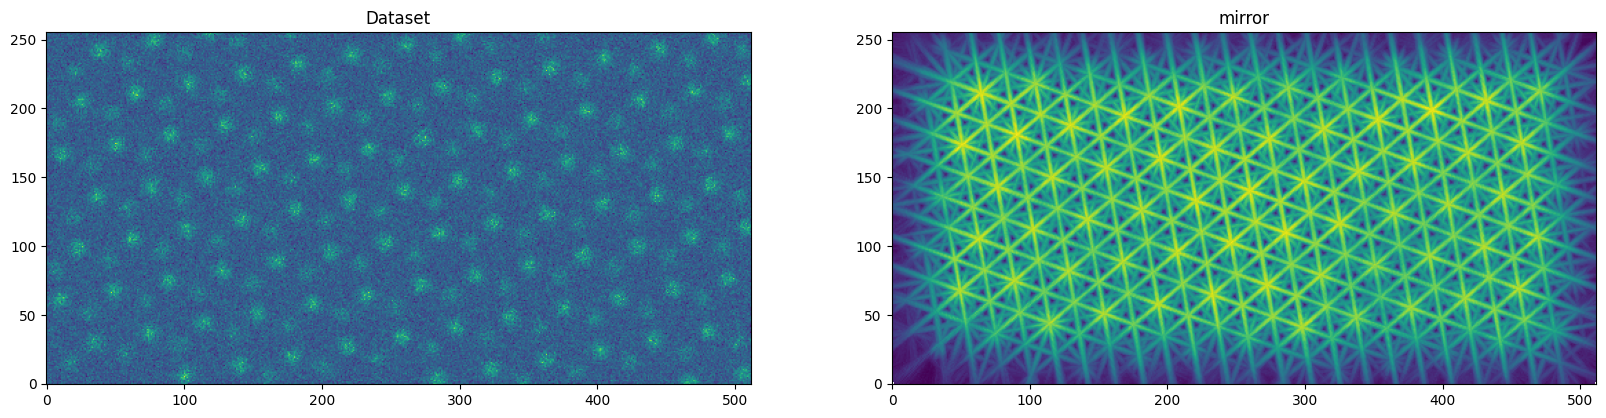

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi = 100)
ax[0].imshow(Dataset,origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(np.max(swCC*swCounts,axis=2),origin='lower')
ax[1].set_title('mirror')